In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


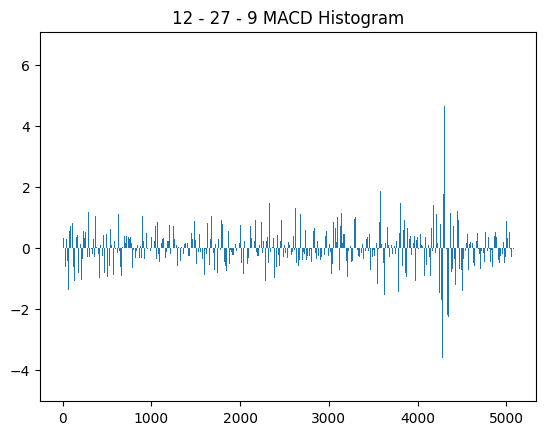

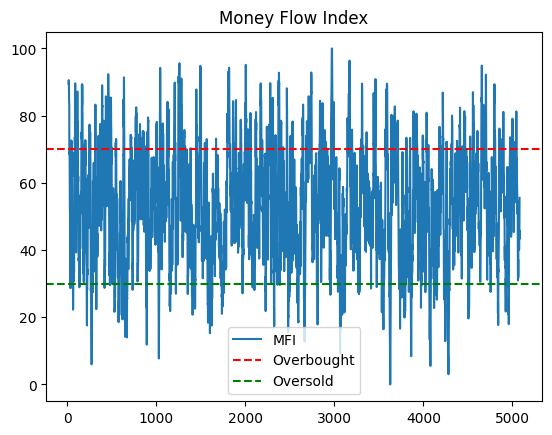

                            OLS Regression Results                            
Dep. Variable:      3 Period % Change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8013
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.524
Time:                        15:19:49   Log-Likelihood:                 6088.3
No. Observations:                1678   AIC:                        -1.217e+04
Df Residuals:                    1673   BIC:                        -1.214e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.237      0.8

Price,Adj Close,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,...,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB,RSI,Close + 3,3 Period % Change,Predictions,Residuals
0,387.339905,387.339905,387.440002,385.779999,386.950012,6609998,386.337128,384.725314,1.611814,1.477281,...,384.568933,3.097042,390.763017,378.374849,0.276321,71.884965,386.220001,-0.002891,0.000181,0.003073
1,386.220001,386.220001,387.450012,386.000000,386.660004,20216545,386.430134,385.108343,1.321791,1.449889,...,385.114153,3.059262,391.232676,378.995629,0.409631,70.021273,384.480011,-0.004505,0.000180,0.004685
2,384.480011,384.480011,386.019989,383.290009,384.482300,13158187,385.867745,385.098257,0.769488,1.207921,...,385.667812,2.619794,390.907400,380.428223,0.613349,38.030349,384.779999,0.000780,0.000617,-0.000163
3,384.779999,384.779999,385.799988,384.270111,385.059998,7466625,385.486621,385.058930,0.427691,0.870458,...,386.338316,1.464715,389.267746,383.408887,0.765976,27.691791,382.640015,-0.005562,0.000865,0.006427
4,382.640015,382.640015,383.119995,382.149994,382.290009,5780321,384.524517,384.663215,-0.138698,0.466115,...,385.997815,1.846288,389.690390,382.305239,0.954669,19.227806,387.869995,0.013668,0.000892,-0.012776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,659.179993,659.179993,660.570007,658.500000,660.200012,12745726,659.549350,658.706322,0.843028,1.184200,...,659.846326,0.595465,661.037256,658.655396,0.779753,36.829590,663.460022,0.006493,0.000446,-0.006047
1675,663.460022,663.460022,663.940002,662.175110,663.309998,7237612,661.176801,659.702883,1.473918,1.268114,...,660.370004,1.561120,663.492243,657.247765,0.005160,65.764985,662.710022,-0.001130,-0.000079,0.001051
1676,662.710022,662.710022,663.510010,662.340027,662.780029,10496656,661.856809,660.344218,1.512591,1.395899,...,660.769257,1.814239,664.397735,657.140778,0.232565,61.099109,660.760010,-0.002942,-0.000008,0.002934
1677,660.760010,660.760010,662.210022,660.630005,661.900024,17767234,661.744008,660.598269,1.145738,1.342134,...,661.043753,1.805598,664.654950,657.432556,0.539287,57.398411,662.530029,0.002679,0.000053,-0.002625


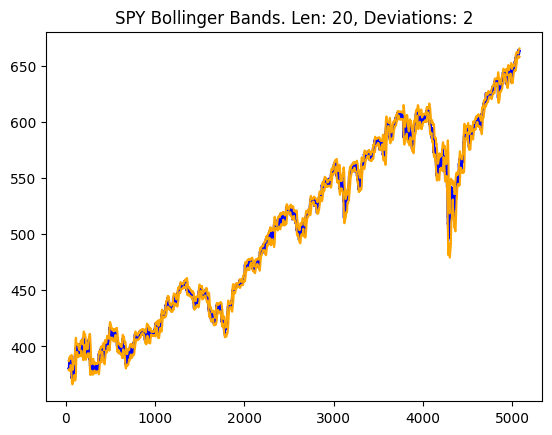

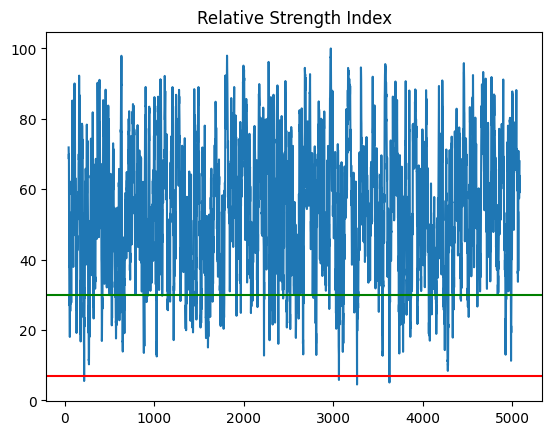

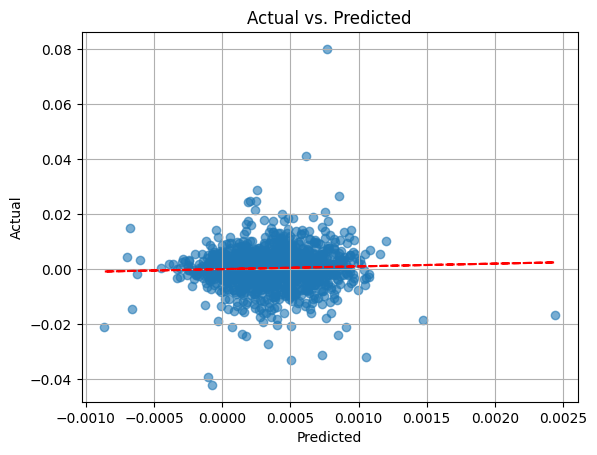

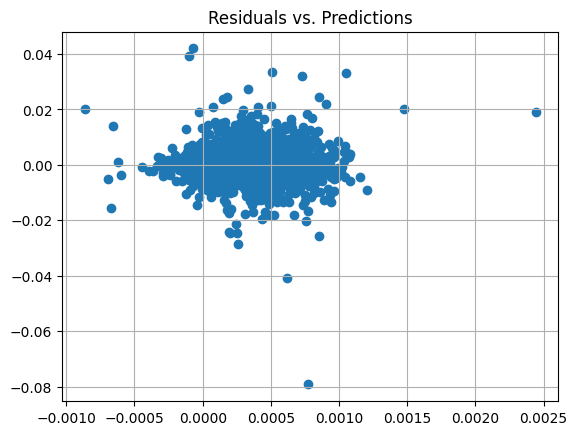

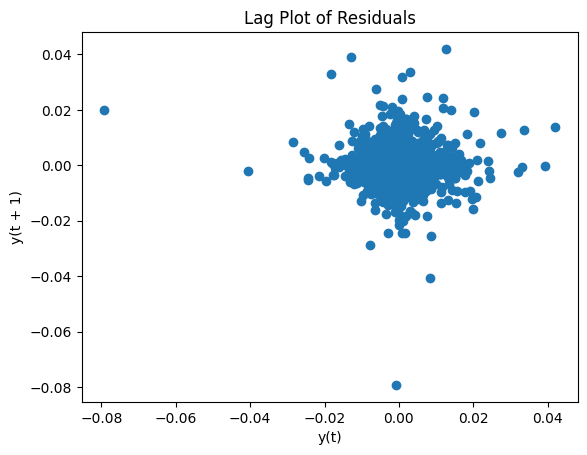

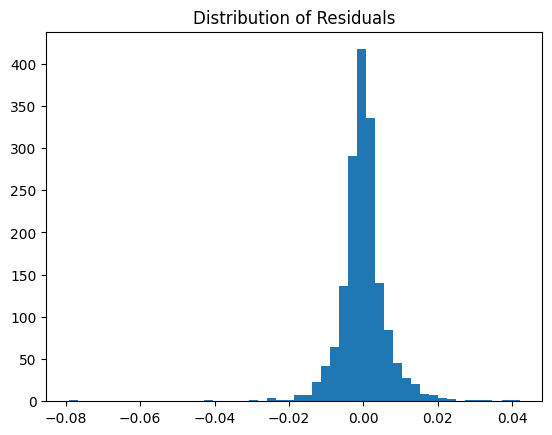

In [2]:
TICKER = 'SPY'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 3
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_LENGTH = 14
RSI_OVERBOUGHT = 7
RSI_OVERSOLD = 30
BB_LEN = 20
DEVS = 2

# what subsetion of that data are you interested in
LOOKBACK = 10000

STRATEGY = ['MACD_hist', 'MFI', 'BB', 'RSI']

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):
    df = df.copy()

    # Step 1: Calculate typical price
    df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Step 2: Calculate raw money flow
    df['Raw_Money_Flow'] = df['Typical_Price'] * df['Volume']

    # Step 3: Classify positive/negative money flow
    df['Price_Change'] = df['Typical_Price'].diff()

    df['Pos_Flow'] = np.where(df['Price_Change'] > 0, df['Raw_Money_Flow'], 0)
    df['Neg_Flow'] = np.where(df['Price_Change'] < 0, df['Raw_Money_Flow'], 0)

    # Step 4: Money Flow Ratio and MFI
    pos_sum = df['Pos_Flow'].rolling(window=length).sum()
    neg_sum = df['Neg_Flow'].rolling(window=length).sum()
    mfr = pos_sum / neg_sum
    df['MFI'] = 100 - (100 / (1 + mfr))

    # Step 5: Plot
    plt.figure()
    plt.plot(df['MFI'], label='MFI')
    plt.axhline(overbought, color='red', linestyle='--', label='Overbought')
    plt.axhline(oversold, color='green', linestyle='--', label='Oversold')
    plt.title('Money Flow Index')
    plt.legend()
    plt.show()

    return df.dropna()

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df['BB'] = (df['Upper_Band'] - df['Close']) / (df['Upper_Band'] - df['Lower_Band'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')
    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.figure()
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT, interval=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']
    
    # fix autocorrelation within target
    df = df.iloc[::interval].reset_index(drop=True)

    return df

def generate_regression_output(df, features=STRATEGY, target=f'{SHIFT} Period % Change'):
    subset = df[features + [target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficients = model.params.drop('const')
    r2 = model.rsquared
    p_values = model.pvalues.drop('const')
    model_p_value = model.f_pvalue  # overall model significance
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())

    # Plot actual vs predicted
    plt.figure()
    plt.scatter(y_pred, y, alpha=0.6)
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)

    return df, intercept, coefficients, model_p_value

def validate_regression_output(df, coef, intercept):
    df['Predictions'] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature]

    df['Residuals'] = df['Predictions'] - df[f'{SHIFT} Period % Change']

    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Residuals vs. Predictions')
    plt.grid(True)

    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals')

    plt.figure()
    plt.hist(df['Residuals'].dropna(), bins=50)
    plt.title('Distribution of Residuals')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)

    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df